# sensitvity to value of pseudo-count
 * testing the convergence of model with updated priors for different pseudo-count values
 * see [this notebook](/experimental/experimental_zinser_seaflow_20200616_gallery1_pseudocountsens.ipynb) for results of older priors
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

num_pseudocounts = [100, 1000, 10_000, 100_000, 1_000_000]

# load data
datafiles = {}
desc = {}

for npc in num_pseudocounts:
    datafiles['seaflow '+str(npc)] = 'data/SeaFlow_SizeDist_regrid-25-8.nc'
    desc['seaflow '+str(npc)] = 'SeaFlow dataset (pseudo count {})'.format(npc)
    datafiles['zinser '+str(npc)] = 'data/Zinser_SizeDist_calibrated-26-6.nc'
    desc['zinser '+str(npc)] = 'Zinser dataset (pseudo count {})'.format(npc)
    
itestfiles = {k:'data/Zinser_SizeDist_calibrated-26-6-itest.csv' for k in datafiles}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)
'''
for i,dataname in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('raw data', size=20)
    
    ax = axs[0]
    ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[dataname]['v_min']
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[dataname]['time'],v,data_gridded[dataname]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
'''
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[dataname]['time'][-1]/binsize))
        
        data[dataname]['obs'] = np.full((data[dataname]['m'],numbins), fill_value=np.nan)
        data[dataname]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[dataname]['time'] >= ibin*binsize,
                                    data_gridded[dataname]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[dataname]['obs'][:,i] = np.mean(data_gridded[dataname]['w_obs'][:,binind], axis=1)
                data[dataname]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[dataname]['obs'] = data[dataname]['obs'][:,:i]
        data[dataname]['t_obs'] = data[dataname]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    ## load cross-validation testing indices and add them to data
    #data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    ## remove last index, so that dimensions agree
    #data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    
    # set all indices to zero
    data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # for now, add pseudo-count data
    
    psc = int(dataname.split()[1])
    print('for "{}" psc={}'.format(dataname, psc))
    data[dataname]['obs_count'] = (psc*data[dataname]['obs']).astype(int)
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

for "seaflow 100" psc=100
for "zinser 100" psc=100
for "seaflow 1000" psc=1000
for "zinser 1000" psc=1000
for "seaflow 10000" psc=10000
for "zinser 10000" psc=10000
for "seaflow 100000" psc=100000
for "zinser 100000" psc=100000
for "seaflow 1000000" psc=1000000
for "zinser 1000000" psc=1000000


In [4]:
'''
for i,dataname in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('processed data', size=20)
    
    ax = axs[0]
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    ax.plot(t, data[dataname]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')
'''
None

## run model

In [5]:
import pystan
import re

desc_model = {
    #'s1':'m5',
    #'s2':'m5 mlmn',
    's3':'m5 update',
}
# preparing for some regular expression magic
model_code_replacements = {
    's1':(),
    's2':(),
    's3':(),
    's4':(),
    's5':(),
    's6':(),
    's7':(),
    's8':(),
    's9':(),
}
model_stan_key = {
    's1':'c5',
    's2':'c5mlmn',
    's3':'c5update',
}
stan_files = {
    'c1':'stancode_gallery1/matrixmodel_multinom_estinilnorm_freedelta_normparam_trackgrowth_xval.stan',
    'c2':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_normparam_trackgrowth_xval.stan',
    'c3':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_gammaiv6_normparam_trackgrowth_xval.stan',
    'c4':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv1_normparam_trackgrowth_xval.stan',
    'c5':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'c5mlmn':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'c6':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',
    'c7':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',
    'c8':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv6_normparam_trackgrowth_xval.stan',
    'c9':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv7_normparam_trackgrowth_xval.stan',
    'c10':'stancode_gallery1/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    'c56':'stancode/matrixmodel_multinom_estinilnorm_monodelta_resp_gammaiv6_normparam_trackgrowth_xval.stan',
    'c57':'stancode/matrixmodel_multinom_estinilnorm_monodelta_resp_gammaiv7_normparam_trackgrowth_xval.stan',
    'c5update':'stancode_gallery1/mlmn_version/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowth_xval2.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for name in desc_model:
    code_split = stan_base_code[model_stan_key[name]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[name]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(name, line_new))
        code_split_new.append(line_new)
                
    stan_code[name] = '\n'.join(code_split_new)

for name in desc_model:
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code[name]:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(model_code=stan_code[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL s3 NOW.


s3: compiling


In [6]:
import time
refit_all = False

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

def get_mean_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmean(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}
if 'meanrhats' not in globals():
    meanrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}

    
try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    if name not in meanrhats:
        meanrhats[name] = {}
    if name not in sampling_time:
        sampling_time[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if dataname not in meanrhats[name]:
            meanrhats[name][dataname] = []
        if dataname not in sampling_time[name]:
            sampling_time[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            t0 = time.time()
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            sampling_time[name][dataname].append(time.time() - t0) # in seconds
            meanrhats[name][dataname].append(get_mean_rhat(mcmcs[name][dataname]))
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 1/3 found Rhat=1.952, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 2/3 found Rhat=1.554, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 3/3 found Rhat=1.950, trying again
s3 (m5 update)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          45.03    1.99  12.19  24.41  35.92  43.02  54.38  69.34     38    1.1
gamma_max           1.89    0.06   0.54   1.26   1.55   1.67   2.11   3.29     79   1.09
rho_max             0.03  2.0e-3   0.03 2.1e-3   0.02   0.03   0.04    0.1    161   1.02
E_star            1074.6   80.55 759.16  69.08 477.28 978.56 1437.8 2959.8     89   1.05
sigma              8.2e4   6.2e4  1.1e5 8689.3  2.1e4  2.8e4  6.9e4  3.9e5      3   1.78
divrate             0.78    0.01   0.07   0.67   0.71   0.77   0.83   0.92     34   1.14
delta[1]            0.02  2.9e-3   0.02 6.0e-4 2.5e-3   0.01   0.03   0.08     52   1.07
delta[2]            0.96    0.02   0.16   0.71   0.82   0.95   1.07   1.31     

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 1/3 found Rhat=1.209, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 2/3 found Rhat=2.389, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 3/3 found Rhat=2.551, trying again
s3 (m5 update)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          11.68    0.41   1.76   9.03  10.39   11.3  12.79  15.95     19   1.13
gamma_max           5.18    0.48   1.27   4.09    4.4   4.54   5.51   8.42      7   1.51
rho_max             1.49    0.04   0.12   1.24   1.41    1.5   1.58   1.71     10   1.42
E_star            116.41   29.36  78.28  38.86  63.75  81.41 147.76 304.19      7   1.55
sigma              1.0e5   5.1e4  9.9e4 8647.2  2.3e4  5.4e4  2.0e5  3.2e5      4   2.23
divrate             0.73    0.02   0.07   0.57   0.69   0.74   0.77   0.86     17   1.34
delta[1]          4.9e-3  7.6e-4 5.4e-3 6.7e-5 7.4e-4 3.0e-3 6.9e-3   0.02     50   1.09
delta[2]          9.5e-3  1.6e-3 7.3e-3 1.4e-3 3.4e-3 8.1e-3   0.01   0.03     

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 1/3 found Rhat=1.244, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (m5 update)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          55.76    0.61  12.79  27.93  46.38  58.71  67.02   71.6    446   1.02
gamma_max            1.4  4.0e-3    0.1   1.28   1.35   1.39   1.43   1.65    596    1.0
rho_max             0.06  6.4e-4   0.02   0.01   0.04   0.06   0.07    0.1   1301   1.01
E_star             237.8    10.5 239.21  34.33  78.16 137.63 326.23 880.63    519    1.0
sigma             2390.3   27.53  435.9 1714.6 2089.5 2321.6 2623.9 3423.9    251   1.02
divrate             0.66  1.2e-3   0.03   0.59   0.64   0.66   0.68   0.73    807   1.01
delta[1]            0.08  9.5e-4   0.03   0.02   0.06   0.08   0.11   0.15   1228   1.01
delta[2]            1.02  2.6e-3   0.08   0.86   0.97   1.02   1.08   1.18   1048    1.0
delta[3]            1.26  3.2e-3   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 1/3 found Rhat=11.899, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (m5 update)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          30.82    0.41  10.44  15.65  22.48  29.86  37.14  55.87    663   1.01
gamma_max           4.53    0.01   0.37   4.08   4.29   4.45   4.67   5.46   1080    1.0
rho_max             1.55  1.7e-3   0.06   1.43   1.51   1.55   1.59   1.68   1441    1.0
E_star             88.85    0.77  25.47  52.51  71.86  84.58 100.23 150.52   1088    1.0
sigma             710.35    2.21  73.24 578.67 658.16 705.23 758.94  859.3   1095    1.0
divrate             0.63  9.2e-4   0.05   0.54    0.6   0.63   0.67   0.73   2592    1.0
delta[1]          9.4e-3  1.1e-4 8.2e-3 3.0e-4 3.1e-3 7.1e-3   0.01   0.03   5104    1.0
delta[2]            0.02  1.6e-4   0.01 2.9e-3   0.01   0.02   0.03   0.04   5001    1.0
delta[3]            0.03  1.9e-4   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 1/3 found Rhat=1.119, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (m5 update)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          60.29    0.59  11.16  33.39  53.36  64.37  69.28  71.77    360   1.03
gamma_max           1.45  4.9e-3   0.13    1.3   1.37   1.42   1.48   1.81    712    1.0
rho_max             0.06  6.8e-4   0.02   0.01   0.05   0.06   0.08    0.1   1136    1.0
E_star            315.44   11.15 290.77  40.68  95.57 210.35 455.07 1074.6    681   1.01
sigma             766.81    1.01  46.31 678.56 734.27 766.16 798.21 860.74   2098    1.0
divrate             0.66  7.8e-4   0.03   0.59   0.64   0.66   0.68   0.72   1733    1.0
delta[1]            0.07  1.0e-3   0.03 8.7e-3   0.04   0.06   0.09   0.14   1130    1.0
delta[2]            0.99  1.8e-3   0.08   0.83   0.93   0.99   1.04   1.14   2010    1.0
delta[3]            1.27  3.0e-3   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (m5 update)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           23.9    0.12   5.86  16.04  20.17  22.75  26.14  39.55   2382    1.0
gamma_max           4.45  7.1e-3   0.32   4.07   4.26   4.39   4.57   5.21   2020    1.0
rho_max             1.56  1.1e-3   0.06   1.44   1.52   1.56   1.61   1.69   3662    1.0
E_star             85.83    0.47   22.5  52.22  71.29  81.99  96.02 138.99   2268    1.0
sigma             411.82    0.42   25.1 363.99 394.42 410.94 428.42 462.91   3610    1.0
divrate             0.61  7.3e-4   0.04   0.53   0.58   0.61   0.64    0.7   3676    1.0
delta[1]          8.7e-3  1.0e-4 7.9e-3 1.8e-4 2.7e-3 6.5e-3   0.01   0.03   5857    1.0
delta[2]            0.02  1.5e-4   0.01 2.7e-3 9.9e-3   0.02   0.02   0.04   5128    1.0
delta[3]            0.03  1.7e-4   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 1/3 found Rhat=1.229, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (m5 update)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          64.43    0.53   9.24  38.78  61.55   68.4  70.71  71.91    307   1.03
gamma_max           1.44  3.8e-3   0.13    1.3   1.37   1.41   1.47   1.78   1162    1.0
rho_max             0.06  4.0e-4   0.02   0.02   0.05   0.06   0.08    0.1   3050    1.0
E_star            299.41    8.03 280.68   39.1  95.73 199.81 428.06 1054.2   1222    1.0
sigma             714.65    0.65  41.76 635.64  685.7 713.75 742.65 799.02   4068    1.0
divrate             0.66  7.3e-4   0.03    0.6   0.64   0.66   0.68   0.72   2052    1.0
delta[1]            0.06  6.6e-4   0.03 6.8e-3   0.04   0.06   0.09   0.14   2578    1.0
delta[2]            0.98  1.4e-3   0.08   0.82   0.93   0.98   1.04   1.14   3328    1.0
delta[3]            1.27  2.1e-3   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3: in try 1/3 found Rhat=13.887, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (m5 update)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          23.52     0.1   5.21  15.91  20.21  22.74   25.8  36.23   2700    1.0
gamma_max           4.45  7.3e-3   0.33   4.06   4.24   4.39   4.57    5.2   2065    1.0
rho_max             1.57  9.9e-4   0.06   1.44   1.52   1.56   1.61   1.69   4270    1.0
E_star             85.77    0.48  23.33  52.83  71.13  82.02  96.52 136.54   2357    1.0
sigma             394.58    0.34  23.06 350.33 378.45 394.23 410.13  440.8   4563    1.0
divrate             0.61  6.6e-4   0.04   0.52   0.58   0.61   0.64    0.7   4324    1.0
delta[1]          8.5e-3  1.0e-4 7.7e-3 2.0e-4 2.6e-3 6.4e-3   0.01   0.03   5530    1.0
delta[2]            0.02  1.4e-4   0.01 2.3e-3 9.5e-3   0.02   0.02   0.04   5253    1.0
delta[3]            0.03  1.6e-4   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (m5 update)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          65.54    0.57   8.63  39.89  64.16  69.32  71.13  71.94    231   1.01
gamma_max           1.44  7.2e-3   0.13   1.29   1.37   1.41   1.47   1.77    340   1.01
rho_max             0.06  9.3e-4   0.02   0.01   0.05   0.06   0.08    0.1    630    1.0
E_star            293.92   13.65 280.92  42.18  92.39 189.85  414.7 1018.5    424   1.01
sigma             711.12    0.62  40.88 633.17 684.32 710.43 737.92 791.01   4364    1.0
divrate             0.66  9.3e-4   0.03    0.6   0.64   0.66   0.68   0.73   1268    1.0
delta[1]            0.07  1.4e-3   0.04 8.0e-3   0.04   0.06   0.09   0.14    615    1.0
delta[2]            0.99  1.8e-3   0.08   0.83   0.93   0.99   1.03   1.14   1900    1.0
delta[3]            1.27  2.7e-3   0

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s3 (m5 update)
Inference for Stan model: s3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max          23.65    0.13   5.41  16.42  20.19  22.74  25.79  37.09   1724    1.0
gamma_max           4.45  7.9e-3   0.32   4.06   4.25   4.39   4.57   5.28   1609    1.0
rho_max             1.56  1.1e-3   0.06   1.44   1.52   1.56   1.61   1.69   3468    1.0
E_star             86.27    0.54  22.52  54.35  71.25  82.56  96.72  143.6   1760    1.0
sigma             393.42    0.29  22.75  350.1 377.81 393.32 408.63  439.1   6345    1.0
divrate             0.61  6.5e-4   0.04   0.52   0.58   0.61   0.64    0.7   4563    1.0
delta[1]          8.6e-3  9.4e-5 7.6e-3 2.5e-4 2.7e-3 6.6e-3   0.01   0.03   6540    1.0
delta[2]            0.02  1.3e-4   0.01 2.8e-3 9.8e-3   0.02   0.02   0.04   6403    1.0
delta[3]            0.03  1.5e-4   0

## plot the results

In [7]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}        

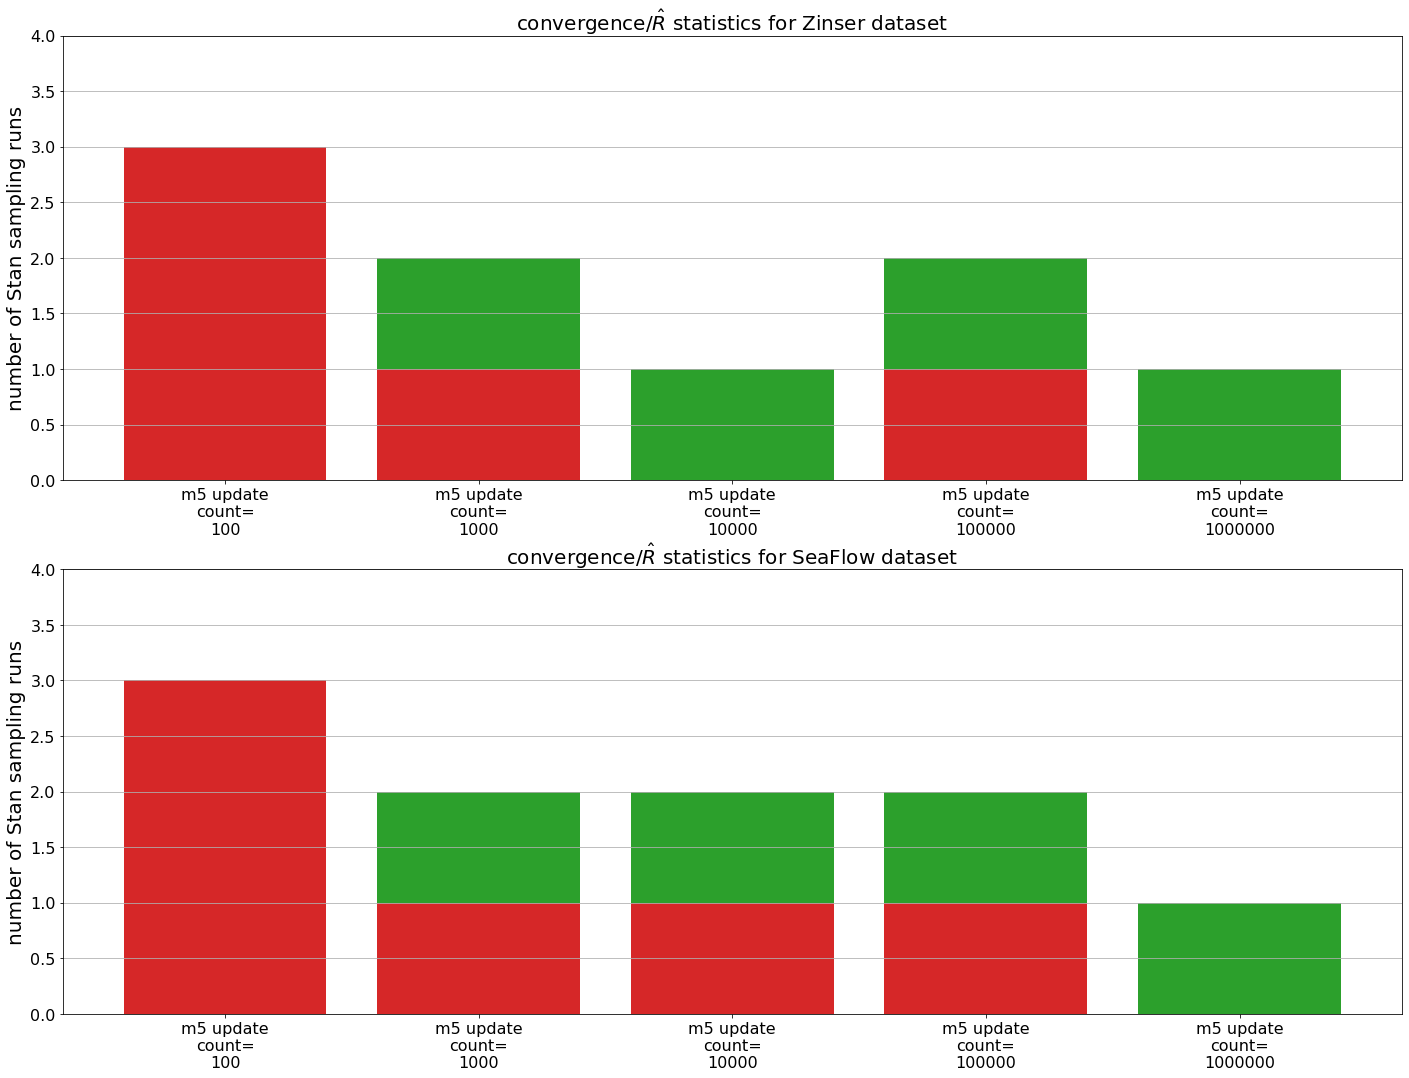

In [8]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=2, figsize=(max(24,len(mcmcs)*4.5),2*9), sharey=True)

xticks = ([],[])
xticklabels = ([],[])

for idata,dataname in enumerate(data):
    if 'zinser' in dataname:
        iax = 0
    else:
        iax = 1
    
    ax = axs[iax]
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        x = idata//2*len(mcmcs)+i
        
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks[iax].append(x)
        xticklabels[iax].append(desc_model[name].replace(',',',\n') + '\ncount=\n' + dataname.split()[1])

for iax,ax in enumerate(axs.flat): 
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks[iax], ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{{R}}$ statistics for {} dataset'.format(('Zinser','SeaFlow')[iax]), size=20)
    ax.set_xticklabels(xticklabels[iax])#, rotation=8)
    ax.grid(axis='y')

None